In [1]:
import os 
os.chdir("./Kitsune/")
from netStat_torch import netStat
import AfterImage_torch as af

os.chdir("..")
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
from utils import get_feature_map, load_data
from PytorchAD import AnomalyDetector
import time
import copy

Feature extractor

In [2]:
packages = pickle.load(open("data/mirai_packages.pkl", "rb"))
maxHost = 100000000000
maxSess = 100000000000
Lambdas = torch.tensor([5., 3., 1., .1, .01],dtype=torch.float64)
nstat = netStat(Lambdas, maxHost, maxSess)
mirai_new = []
t0 = time.time()
ts0 = packages[0][-1] # start timestamp
save_checkpoint = False # save nstat object every n iterations for furthur analysis
for i in range(len(packages)):
    if (i+1) % 10000 == 0:
        print("Finished {}. Time: {}s.".format(i+1, time.time()-t0))
        t0 = time.time()
        if save_checkpoint:
            pickle.dump(nstat, open("nstat_torch_save/FE_chkpt/nstat_idx_{}.pkl".format(i), "wb"))
    IPtype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = packages[i]
    datagramSize = torch.tensor(datagramSize, dtype=torch.float64)
    timestamp = torch.tensor(timestamp - ts0, dtype=torch.float64) # due to lack of precision of torch.DoubleTensor 
    new_inst = nstat.updateGetStats(srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp)
    mirai_new.append(new_inst.reshape(1,-1))

mirai_torch = torch.cat(mirai_new)

Finished 10000. Time: 35.42735528945923s.
Finished 20000. Time: 58.06111240386963s.
Finished 30000. Time: 79.20479798316956s.
Finished 40000. Time: 98.34790825843811s.
Finished 50000. Time: 118.57426476478577s.
Finished 60000. Time: 139.0357530117035s.
Finished 70000. Time: 151.5040419101715s.
Finished 80000. Time: 180.32166385650635s.
Finished 90000. Time: 196.00597763061523s.
Finished 100000. Time: 218.87984037399292s.
Finished 110000. Time: 243.71419858932495s.
Finished 120000. Time: 254.58648085594177s.
Finished 130000. Time: 287.7681279182434s.
Finished 140000. Time: 311.801057100296s.
Finished 150000. Time: 311.0818748474121s.
Finished 160000. Time: 313.64520359039307s.
Finished 170000. Time: 314.555947303772s.
Finished 180000. Time: 312.59144353866577s.
Finished 190000. Time: 317.01300597190857s.
Finished 200000. Time: 316.76206517219543s.
Finished 210000. Time: 327.14315009117126s.
Finished 220000. Time: 319.3199837207794s.
Finished 230000. Time: 318.43567728996277s.
Finished 2

In [3]:
saveInputs = True
if saveInputs:
    pickle.dump(mirai_torch, open("data/mirai_vector.pkl", "wb"))

Train AD

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim import SGD
import time
from utils import get_feature_map, load_data
from PytorchAD import AnomalyDetector
import datetime

In [5]:
# Train FM and initialize AD
v = get_feature_map(mirai_torch.numpy(), FMgrace, maxAE)
AD = AnomalyDetector(v, device="cpu")
#AD.load_state_dict(torch.load("AD_model_mirai_state_dict.pt"))
#AD = torch.load("model/AD_model_mirai.pt")
AD.eval()

AnomalyDetector(
  (ensemble_layer): ModuleList(
    (0): Autoencoder()
    (1): Autoencoder()
    (2): Autoencoder()
    (3): Autoencoder()
    (4): Autoencoder()
    (5): Autoencoder()
    (6): Autoencoder()
    (7): Autoencoder()
    (8): Autoencoder()
    (9): Autoencoder()
    (10): Autoencoder()
    (11): Autoencoder()
    (12): Autoencoder()
    (13): Autoencoder()
    (14): Autoencoder()
    (15): Autoencoder()
    (16): Autoencoder()
    (17): Autoencoder()
  )
  (output_layer): Autoencoder()
)

In [6]:
train_AD_data = mirai_torch[FMgrace+1:FMgrace+ADgrace+1].double()

optimizer = SGD(AD.parameters(), lr=0.1)
AD.train()

t0 = time.time()
for i, x in enumerate(train_AD_data):
    if (i+1)%1000 == 0:
        print(i+1,"/",len(train_AD_data),", time: ",time.time()-t0,"s")
        t0 = time.time()
        
    z_list = AD(x.reshape(1,-1))
    optimizer.zero_grad()
    for i, error in enumerate(z_list):
        error.backward()
        optimizer.step()


1000 / 50000 , time:  13.720663070678711 s
2000 / 50000 , time:  12.911009073257446 s
3000 / 50000 , time:  12.84079360961914 s
4000 / 50000 , time:  12.872902870178223 s
5000 / 50000 , time:  12.822038412094116 s
6000 / 50000 , time:  12.974865674972534 s
7000 / 50000 , time:  12.838767766952515 s
8000 / 50000 , time:  12.942131042480469 s
9000 / 50000 , time:  13.028976678848267 s
10000 / 50000 , time:  12.817184686660767 s
11000 / 50000 , time:  13.030756950378418 s
12000 / 50000 , time:  13.045089721679688 s
13000 / 50000 , time:  12.890968799591064 s
14000 / 50000 , time:  12.955795764923096 s
15000 / 50000 , time:  12.984551906585693 s
16000 / 50000 , time:  12.998599767684937 s
17000 / 50000 , time:  12.93635082244873 s
18000 / 50000 , time:  12.887197256088257 s
19000 / 50000 , time:  12.988957166671753 s
20000 / 50000 , time:  12.82764220237732 s
21000 / 50000 , time:  12.766423225402832 s
22000 / 50000 , time:  12.789618492126465 s
23000 / 50000 , time:  12.851203918457031 s


In [13]:
eval_AD_data = mirai_torch[FMgrace+ADgrace+1:].double()
AD.eval()
RMSEs = list(np.zeros(FMgrace+ADgrace+1)) + AD(eval_AD_data).tolist()

C:\Users\qiuhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Plotting results


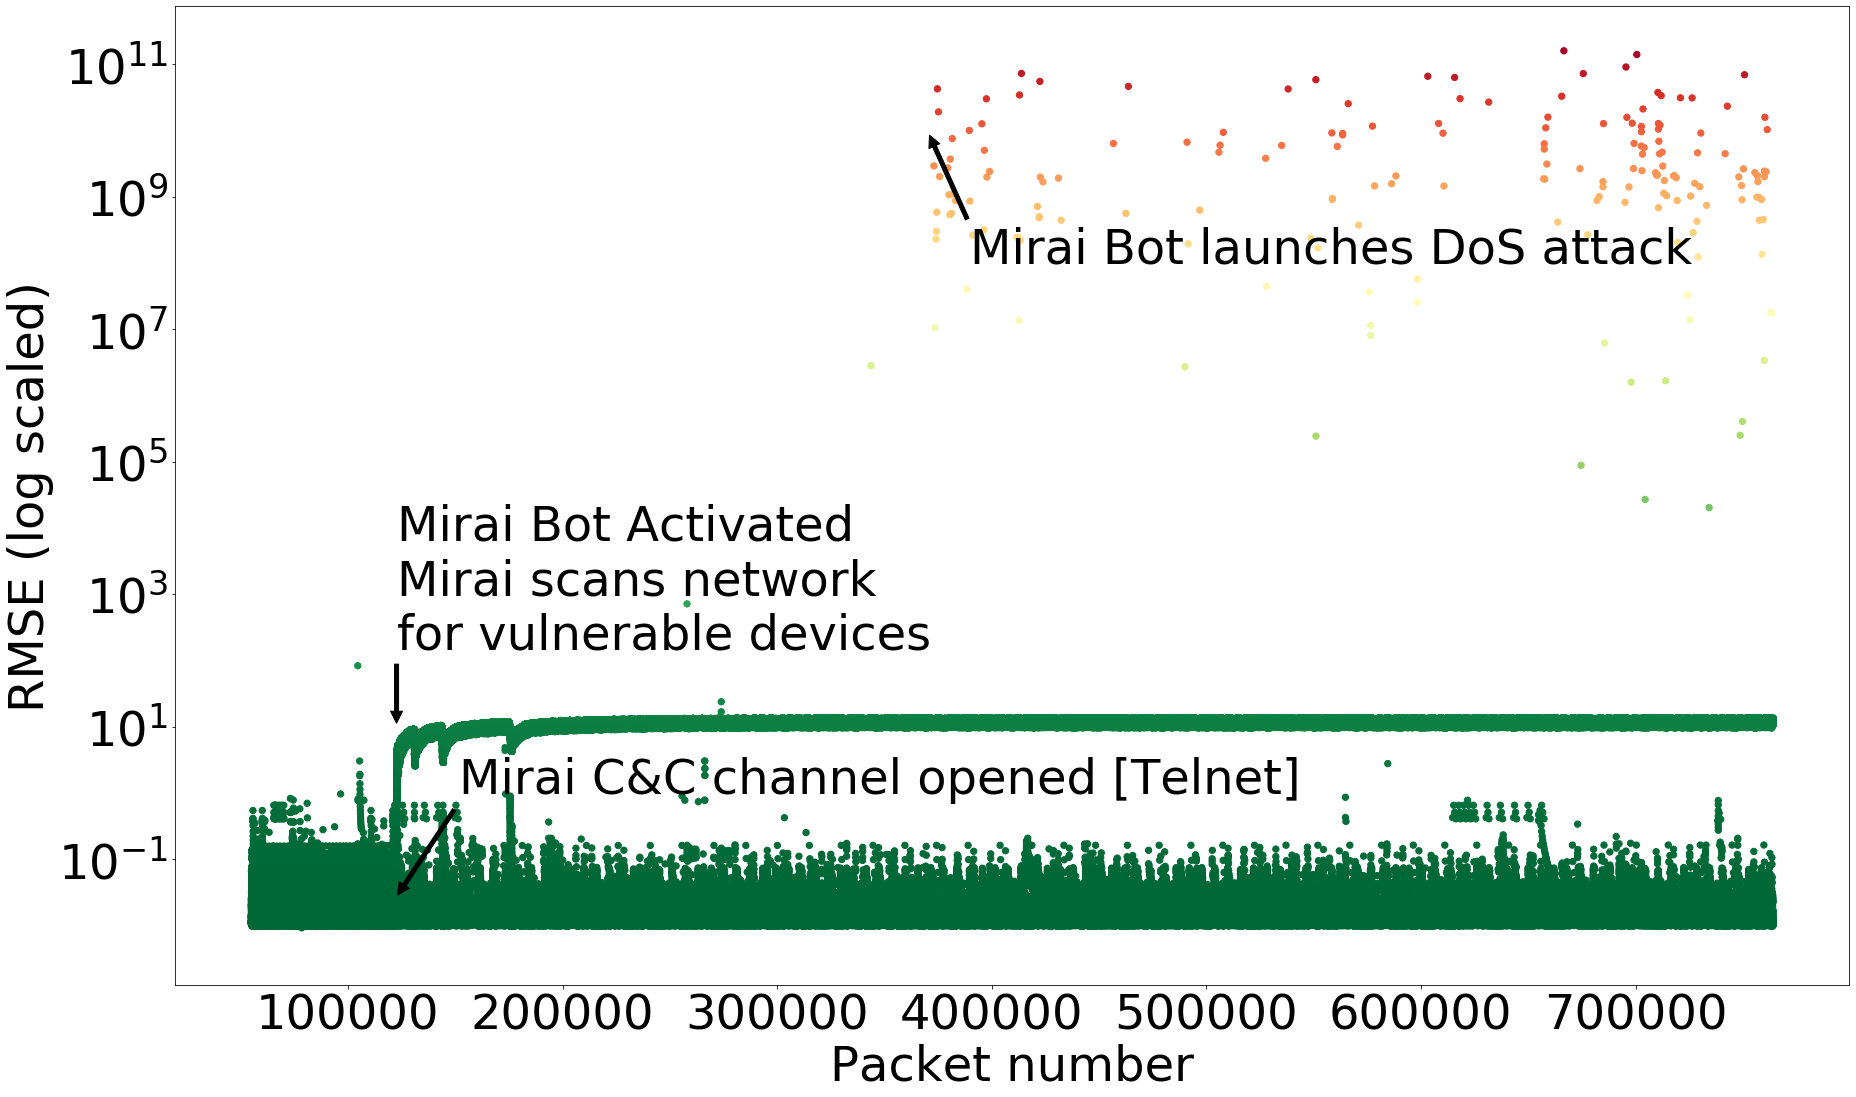

In [17]:
# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
import matplotlib
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:100000])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample))

# plot the RMSE anomaly scores
print("Plotting results")
from matplotlib import pyplot as plt
from matplotlib import cm
font = {'size':48}
matplotlib.rc('font', **font)
plt.figure(figsize=(30,18))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=40,c=logProbs[FMgrace+ADgrace+1:],cmap='RdYlGn')
plt.yscale("log")
#plt.title("Anomaly Scores from Kitsune's Execution Phase")
plt.ylabel("RMSE (log scaled)")
plt.xlabel("Packet number")
plt.annotate('Mirai C&C channel opened [Telnet]', xy=(121662,RMSEs[121662]), xytext=(151662,1),arrowprops=dict(facecolor='black', shrink=0.05),)
plt.annotate('Mirai Bot Activated\nMirai scans network\nfor vulnerable devices', xy=(122662,10), xytext=(122662,150),arrowprops=dict(facecolor='black', shrink=0.05),)
plt.annotate('Mirai Bot launches DoS attack', xy=(370000,int(1e10)), xytext=(390000,int(1e8)),arrowprops=dict(facecolor='black', shrink=0.05),)
#figbar=plt.colorbar()
#figbar.ax.set_ylabel('Log Probability\n ', rotation=270)

#plt.savefig("result/pytorch_mirai_result.png", bbox_inches='tight', dpi=300)
plt.savefig("result/pytorch_mirai_result.pdf")
plt.show()

Save state dict of model

In [9]:
torch.save(AD.state_dict(), "model/AD_model_state_dict.pt")
torch.save(AD, "model/AD_model.pt")

Save nstat objects related to Dos attack packets

In [ ]:
dos_attack_idx = np.where(np.array(RMSEs)>100)[0]
if save_checkpoint:
    # recreate attack nstat object using the checkpoint objects if there exists
    for x in dos_attack_idx:
        print(x)
        # find the closest checkpoint object
        chk = str(int(x/10000)-1)+'9999'
        nstat = pickle.load(open("nstat_torch_save/FE_chkpt/nstat_idx_{}.pkl".format(chk), "rb"))
        chk_idx = int(chk)
    
    while chk_idx < x:
        
        IPtype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = packages[chk_idx]
        datagramSize = torch.tensor(datagramSize, dtype=torch.float64)
        timestamp = torch.tensor(timestamp - ts0, dtype=torch.float64)# due to lack of precision of torch.DoubleTensor 
        new_inst = nstat.updateGetStats(srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp)
        
        chk_idx += 1
    pickle.dump(nstat, open("nstat_torch_save/FE_attack/nstat_idx_{}.pkl".format(x), "wb"))